# Custom CNN for Coin Grade Classification

Train a custom CNN from scratch on rectangular coin images (preserving 2:1 aspect ratio).

## Features
- ✅ Preserves rectangular aspect ratio (6000x3000 → 512x256)
- ✅ VGG-style architecture with 5 convolutional blocks
- ✅ Data augmentation to prevent overfitting
- ✅ TensorBoard logging
- ✅ Automatic best model saving

## Before Running
Make sure you've prepared your dataset:
```bash
python prepare_dataset.py
```

## Step 1: Import Libraries

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import os

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Step 2: Configuration

Adjust these parameters based on your GPU memory and dataset size.

In [19]:
# Image dimensions (preserves 2:1 aspect ratio)
IMAGE_WIDTH = 2048   # Original: 6000
IMAGE_HEIGHT = 1024  # Original: 3000

# Training hyperparameters
BATCH_SIZE = 4
NUM_EPOCHS = 50
LEARNING_RATE = 0.001

# Device selection (GPU if available)
DEVICE = torch.device('cuda' if torch.cuda.is_available() 
                     else 'mps' if torch.backends.mps.is_available() 
                     else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Image size: {IMAGE_WIDTH}x{IMAGE_HEIGHT}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")

Using device: mps
Image size: 2048x1024
Batch size: 4
Epochs: 50


## Step 3: Define Custom CNN Architecture

VGG-style architecture optimized for rectangular coin images.

In [20]:
class CoinClassifier(nn.Module):
    """
    Custom CNN for coin grade classification.
    Preserves rectangular aspect ratio (width:height = 2:1)
    
    Architecture:
    - Block 1: 3 → 64 channels
    - Block 2: 64 → 128 channels
    - Block 3: 128 → 256 channels
    - Block 4: 256 → 512 channels
    - Block 5: 512 → 512 channels
    - Fully connected layers with dropout
    """
    def __init__(self, num_classes):
        super(CoinClassifier, self).__init__()
        
        # Block 1: 3 -> 64 channels
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 512x256 -> 256x128
        
        # Block 2: 64 -> 128 channels
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 256x128 -> 128x64
        
        # Block 3: 128 -> 256 channels
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 128x64 -> 64x32
        
        # Block 4: 256 -> 512 channels
        self.conv8 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)  # 64x32 -> 32x16
        
        # Block 5: 512 -> 512 channels
        self.conv11 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)  # 32x16 -> 16x8
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 16 * 8, 2048)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048, 1024)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Block 3
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool3(x)
        
        # Block 4
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.pool4(x)
        
        # Block 5
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool5(x)
        
        # Fully connected
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

print("✓ Model architecture defined")

✓ Model architecture defined


## Step 4: Load and Prepare Dataset

Load coin images with data augmentation for training.

In [21]:
# Transforms for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transforms for validation/test (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
training_dataset = datasets.ImageFolder('coin_dataset/train', transform=train_transform)
testing_dataset = datasets.ImageFolder('coin_dataset/test', transform=test_transform)
validation_dataset = datasets.ImageFolder('coin_dataset/val', transform=test_transform)

# Get class labels
classes = training_dataset.classes
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes (grades): {classes}")
print(f"\nDataset sizes:")
print(f"  Training: {len(training_dataset)} images")
print(f"  Testing: {len(testing_dataset)} images")
print(f"  Validation: {len(validation_dataset)} images")

Number of classes: 13
Classes (grades): ['ag03', 'f12', 'f15', 'g04', 'g06', 'vf20', 'vf25', 'vf30', 'vf35', 'vg08', 'vg10', 'xf40', 'xf45']

Dataset sizes:
  Training: 299 images
  Testing: 83 images
  Validation: 54 images


## Step 5: Create Data Loaders

In [22]:
training_loader = torch.utils.data.DataLoader(
    training_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

testing_loader = torch.utils.data.DataLoader(
    testing_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

print(f"Batches per epoch: {len(training_loader)}")
print("✓ Data loaders created")

Batches per epoch: 75
✓ Data loaders created


## Step 6: Visualize Sample Images

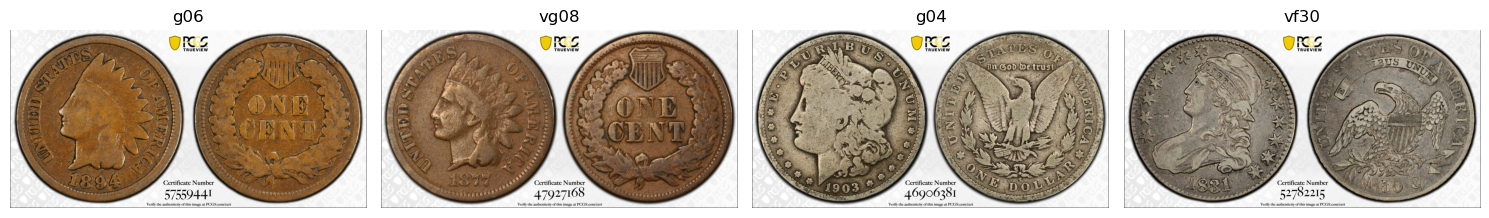

In [23]:
def imshow(img, title=None):
    """Display image from tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(training_loader))

# Show images
fig, axes = plt.subplots(1, min(4, BATCH_SIZE), figsize=(15, 4))
for idx in range(min(4, BATCH_SIZE)):
    if min(4, BATCH_SIZE) > 1:
        ax = axes[idx]
    else:
        ax = axes
    plt.sca(ax)
    imshow(images[idx], title=classes[labels[idx]])
plt.tight_layout()
plt.show()

## Step 7: Initialize Model

In [24]:
model = CoinClassifier(num_classes=num_classes)
model = model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB (float32)")

Total parameters: 148,686,157
Trainable parameters: 148,686,157
Model size: ~567.2 MB (float32)


## Step 8: Define Loss, Optimizer, and Scheduler

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# TensorBoard
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/coin_custom_{timestamp}')

print(f"✓ Training setup complete")
print(f"TensorBoard logs: runs/coin_custom_{timestamp}")

✓ Training setup complete
TensorBoard logs: runs/coin_custom_20251130_001944


## Step 9: Define Training and Validation Functions

In [26]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i + 1) % 10 == 0:
            print(f'  Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("✓ Training functions defined")

✓ Training functions defined


## Step 10: Train the Model

This will take 2-4 hours on GPU (10-20 hours on CPU).

In [27]:
print("="*60)
print("Starting Training...")
print("="*60)
print(f"Image size: {IMAGE_WIDTH}x{IMAGE_HEIGHT}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print("="*60 + "\n")

best_val_acc = 0.0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    
    # Train
    train_loss, train_acc = train_epoch(model, training_loader, criterion, optimizer, DEVICE)
    
    # Validate
    val_loss, val_acc = validate(model, validation_loader, criterion, DEVICE)
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Log to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)
    writer.add_scalar('Learning_Rate', current_lr, epoch)
    
    # Print stats
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")
    print()
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'classes': classes,
            'config': {
                'image_width': IMAGE_WIDTH,
                'image_height': IMAGE_HEIGHT,
                'num_classes': num_classes
            }
        }, 'coin_classifier_custom_best.pth')
        print(f"  ✓ Saved new best model (Val Acc: {val_acc:.2f}%)\n")

writer.close()
print("="*60)
print("Training Complete!")
print("="*60)
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting Training...
Image size: 2048x1024
Batch size: 4
Learning rate: 0.001
Epochs: 50

Epoch [1/50]


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (4x1048576 and 65536x2048)

## Step 11: Plot Training Curves

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training curves saved as training_curves.png")

## Step 12: Evaluate on Test Set

In [ ]:
# Load best model
checkpoint = torch.load('coin_classifier_custom_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
test_loss, test_acc = validate(model, testing_loader, criterion, DEVICE)

print("="*60)
print("FINAL TEST RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("="*60)

## Step 13: Visualize Predictions

In [ ]:
# Get a batch of test images
images, labels = next(iter(testing_loader))
images_cpu, labels_cpu = images.cpu(), labels.cpu()
images, labels = images.to(DEVICE), labels.to(DEVICE)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    probabilities = torch.softmax(outputs, dim=1)

predictions = predictions.cpu()
probabilities = probabilities.cpu()

# Show images with predictions
num_images = min(4, len(images))
fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

for idx in range(num_images):
    if num_images > 1:
        ax = axes[idx]
    else:
        ax = axes
    plt.sca(ax)
    
    true_label = classes[labels_cpu[idx]]
    pred_label = classes[predictions[idx]]
    confidence = probabilities[idx][predictions[idx]] * 100
    
    color = 'green' if true_label == pred_label else 'red'
    
    imshow(images_cpu[idx], 
           title=f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)')
    ax.title.set_color(color)
    ax.title.set_fontsize(12)
    ax.title.set_weight('bold')

plt.tight_layout()
plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Predictions saved as predictions.png")

## Step 14: Model Summary and Next Steps

In [ ]:
print("="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Model: Custom CNN (VGG-style)")
print(f"Image size: {IMAGE_WIDTH}x{IMAGE_HEIGHT} (2:1 aspect ratio)")
print(f"Total parameters: {total_params:,}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Test accuracy: {test_acc:.2f}%")
print(f"\nModel saved as: coin_classifier_custom_best.pth")
print(f"\nTo view training in TensorBoard:")
print(f"  tensorboard --logdir=runs")
print("="*60)

print("\n📝 Next Steps:")
print("  1. Check TensorBoard for detailed metrics")
print("  2. If accuracy < 85%, collect more data or tune hyperparameters")
print("  3. Use the model for predictions (see next cell)")
print("  4. Consider ensemble with ResNet-50 for even better results")

## Bonus: Use the Model for Predictions

Example code to use your trained model on new coin images.

In [ ]:
def predict_coin_grade(image_path, model, classes, device):
    """
    Predict the grade of a coin image.
    
    Args:
        image_path: Path to coin image
        model: Trained CoinClassifier model
        classes: List of class names
        device: torch device
    
    Returns:
        predicted_grade, confidence, top3_predictions
    """
    from PIL import Image
    
    # Load and transform image
    transform = transforms.Compose([
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
        # Get top 3 predictions
        top3_conf, top3_idx = torch.topk(probabilities, min(3, len(classes)))
        
    predicted_grade = classes[predicted.item()]
    conf_pct = confidence.item() * 100
    
    top3 = [(classes[top3_idx[0][i].item()], top3_conf[0][i].item() * 100) 
            for i in range(min(3, len(classes)))]
    
    return predicted_grade, conf_pct, top3

# Example usage (uncomment and modify path):
# predicted_grade, confidence, top3 = predict_coin_grade(
#     'path/to/coin/image.jpg', 
#     model, 
#     classes, 
#     DEVICE
# )
# 
# print(f"Predicted Grade: {predicted_grade}")
# print(f"Confidence: {confidence:.2f}%")
# print("\nTop 3 Predictions:")
# for grade, conf in top3:
#     print(f"  {grade}: {conf:.2f}%")

print("✓ Prediction function defined")
print("  Uncomment the example code above to test predictions")